In [1]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid, NearestNeighbors
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import (
    BernoulliNB,
    CategoricalNB,
    ComplementNB,
    GaussianNB,
    MultinomialNB,
)
from sklearn.svm import LinearSVC, NuSVC, OneClassSVM, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import KNNImputer
# from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import (
    OneHotEncoder,
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    minmax_scale,
    Normalizer,
    normalize,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import scipy as sp
from joblib import delayed, Parallel
import langdetect
# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black



<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn.vectorizers import (
    FreqVectorizer,
    Doc2Vectorizer,
    AverageVectorizer,
    VaderVectorizer,
)
from tools.sklearn import selection

RUN_LANGDETECT = False

# Run time-consuming grid searches
RUN_SWEEPS = frozenset({"learn"})

FIT_MODELS = frozenset({"svm_4"})

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Data Preparation

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=[
        "text",
        "title",
        "brand",
        "main_cat",
    ],
)
display(df.head())
df.shape

,text,title,brand,main_cat
asin,,,,
1441072241,come tell me how you lived: native american hi...,come tell me how you lived: native american hi...,enter the arena,all beauty
6090113980,prayer rug carpet mat gebetsteppich islamic mu...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,all beauty
7250468162,no7 stay perfect foundation cool vanilla by no...,no7 stay perfect foundation cool vanilla by no7,no7,all beauty
8279996397,imagen bendita por su santidad our lady of cha...,imagen bendita por su santidad our lady of cha...,chango,all beauty
9197882747,hall of femmes: lella vignelli (hall of femmes...,hall of femmes: lella vignelli (hall of femmes),oyster press,all beauty


(3878957, 4)

<IPython.core.display.Javascript object>

In [4]:
# cleaning.info(df)

<IPython.core.display.Javascript object>

In [5]:
df = df.loc[~df.index.duplicated()]
df.shape

(3788215, 4)

<IPython.core.display.Javascript object>

In [6]:
df["brand"] = df.loc[:, "brand"].replace(r"^(\s*)$", "none", regex=True)
df["brand"].value_counts()

none                    161847
generic                  10366
yu-gi-oh!                 7088
magic: the gathering      6522
invicta                   5974
                         ...  
stephen bosniak              1
walter e. senoski            1
numbered game cards          1
jenny sadre-orafai           1
jennifer cervantes           1
Name: brand, Length: 844432, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
skl_token_pattern = r"\b\w\w+\b"
skl_token_pattern

'\\b\\w\\w+\\b'

<IPython.core.display.Javascript object>

In [8]:
df["brand"] = lang.force_ascii(df.loc[:, "brand"], n_jobs=-1)
df["brand"] = lang.regex_tokenize(df.loc[:, "brand"], skl_token_pattern, n_jobs=-1)
df["brand"] = df["brand"].str.join("_")

df["brand"].value_counts()

none                     161849
generic                   10368
yu_gi_oh                   7091
magic_the_gathering        6536
invicta                    5974
                          ...  
crystal_heidel                1
garrett_buhl_robinson         1
sebastian_saiegh              1
charlene_warren               1
james_macfarlane              1
Name: brand, Length: 792830, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
qcut = 0.99
retain_nulls = ["fine art", "luxury beauty", "handmade"]
protected_thresh = 1000

pruned_df = []

for cat, group in df.groupby("main_cat"):
    if group.shape[0] <= protected_thresh:
        pruned_df.append(group)
        continue
    if cat not in retain_nulls:
        group = group.loc[group.brand != "none"]
    print(cat)
    print("-" * len(cat))
    group = utils.prune_categories(group, "brand", qcut=qcut)
    print("\n")
    pruned_df.append(group)

pruned_df = pd.concat(pruned_df)

all beauty
----------
                    Status  Support
crystalage        retained       89
makingcosmetics   retained       80
kroo              retained       70
crest             retained       63
vktech            retained       61
...                    ...      ...
omybigdeal         dropped        1
idealsalons        dropped        1
juicy_couture      dropped        1
pur_sleep          dropped        1
ridgeyard_co_ltd   dropped        1

[5208 rows x 2 columns]


all electronics
---------------
                  Status  Support
sony            retained     1199
panasonic       retained     1134
samsung         retained      880
startech        retained      528
generic         retained      520
...                  ...      ...
gts_cases        dropped        1
master_cables    dropped        1
hsm_of_america   dropped        1
lowel            dropped        1
vivi_audio       dropped        1

[12339 rows x 2 columns]


amazon fashion
--------------
                     

[24551 rows x 2 columns]


handmade
--------
                         Status  Support
none                   retained     2218
marvel                  dropped        3
apple                   dropped        2
monster                 dropped        2
lego                    dropped        1
brenda_elaine_jewelry   dropped        1


health & personal care
----------------------
                        Status  Support
maxiaids              retained      139
liliane_memorials     retained      131
crystalage            retained      115
terravita             retained       89
big_dot_of_happiness  retained       88
...                        ...      ...
immutol__60_capsules   dropped        1
rolecos                dropped        1
hcgenerate             dropped        1
easy_men_clothes       dropped        1
greens_first           dropped        1

[10311 rows x 2 columns]


home audio & theater
--------------------
                         Status  Support
sony                   retain

<IPython.core.display.Javascript object>

In [10]:
pruned_df

,text,title,brand,main_cat
asin,,,,
B000050AUH,philips sonicare standard brush head. sonic wa...,philips sonicare standard brush head,philips_sonicare,all beauty
B000050B62,norelco 5841xl deluxe reflex action cord/cordl...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,all beauty
B000050B63,norelco 6826xl quadra action cord/cordless rec...,norelco 6826xl quadra action cord/cordless rec...,norelco,all beauty
B000050B64,norelco 6865xl quadra action cord/cordless rec...,norelco 6865xl quadra action cord/cordless rec...,norelco,all beauty
B000050B65,norelco 6885xl deluxe quadra action cord/cordl...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,all beauty
...,...,...,...,...
B01HH6JEOC,the sims 4 kids room stuff [online game code]....,the sims 4 kids room stuff [online game code],electronic_arts,video games
B01HIU43S4,1k games sega mega drive game console with wir...,1k games sega mega drive game console with wir...,sega,video games
B01HIZF83S,bioshock: the collection - playstation 4. retu...,bioshock: the collection - playstation 4,2k,video games


<IPython.core.display.Javascript object>

In [11]:
pruned_df.brand.value_counts()

generic                        10176
none                            9030
yu_gi_oh                        7085
magic_the_gathering             6535
invicta                         5966
                               ...  
future_us_inc                      1
superior_sports_invesmtents        1
savfy                              1
knotty_pine_on_the_bayou           1
tractor_supply_company             1
Name: brand, Length: 9748, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
pruned_df.main_cat.value_counts()

amazon home                     170130
amazon fashion                  126160
books                           119701
toys & games                     97824
sports & outdoors                80179
tools & home improvement         79987
automotive                       66913
cell phones & accessories        56983
grocery                          39390
computers                        33940
all electronics                  24930
office products                  24438
camera & photo                   21183
arts, crafts & sewing            18418
industrial & scientific          18388
digital music                    18088
pet supplies                     16215
home audio & theater             15117
musical instruments              13457
video games                      11297
movies & tv                      10468
luxury beauty                     6452
health & personal care            3682
software                          3655
car electronics                   3229
baby                     

<IPython.core.display.Javascript object>

In [13]:
df = pruned_df
df.head()

,text,title,brand,main_cat
asin,,,,
B000050AUH,philips sonicare standard brush head. sonic wa...,philips sonicare standard brush head,philips_sonicare,all beauty
B000050B62,norelco 5841xl deluxe reflex action cord/cordl...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,all beauty
B000050B63,norelco 6826xl quadra action cord/cordless rec...,norelco 6826xl quadra action cord/cordless rec...,norelco,all beauty
B000050B64,norelco 6865xl quadra action cord/cordless rec...,norelco 6865xl quadra action cord/cordless rec...,norelco,all beauty
B000050B65,norelco 6885xl deluxe quadra action cord/cordl...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,all beauty


<IPython.core.display.Javascript object>

In [14]:
df.groupby("main_cat").get_group("arts, crafts & sewing").brand.value_counts()

lantern_press               1030
3drose                       812
beadaholique                 780
sizzix                       688
spellbinders                 593
                            ... 
sparkles_make_it_special      82
vogue_fabrics                 81
azeeda                        80
craftbuddy_us                 80
susan_bates                   80
Name: brand, Length: 97, dtype: int64

<IPython.core.display.Javascript object>

## Engineering the Vocabulary

I engineer the model's vocabulary by preprocessing the text, developing a custom tokenizer, and constructing multi-word expressions. The purpose of the model is to assimilate novel products into Amazon's existing classification scheme. If the vocabulary is to serve that purpose, it will require some *a priori* decision-making.

Before making any decisions, I define a function for creating a vocabulary from a sample of the corpus.

In [15]:
def build_sample_vocab(
    corpus,
    n_docs,
    *,
    tokenizer=None,
    sortby="length",
    random_state=363,
    n_jobs=-1,
):
    # Get sample of corpus
    samp_corpus = corpus.sample(n_docs, random_state=random_state)

    # Tokenize
    if tokenizer is None:
        samp_corpus = lang.space_tokenize(samp_corpus, n_jobs=n_jobs)
    elif isinstance(tokenizer, (str, re.Pattern)):
        # Tokenize using re.findall
        samp_corpus = lang.regex_tokenize(samp_corpus, tokenizer, n_jobs=n_jobs)
    else:
        samp_corpus = lang.process_strings(samp_corpus, tokenizer, n_jobs=n_jobs)

    # Build vocabulary
    vocab = samp_corpus.explode().value_counts()
    vocab = vocab.reset_index(name="freq").rename(columns={"index": "term"})

    # Add additional stats
    vocab["length"] = vocab.loc[:, "term"].str.len()
    vocab["uniq_ratio"] = vocab.loc[:, "term"].map(lang.uniq_ratio)

    return vocab.sort_values(sortby, ascending=False)

<IPython.core.display.Javascript object>

### Optimize the Tokenizer?

There are many tokenizers on the market. Shouldn't I grid-search over them all to maximize my accuracy score?

No. The choice of tokenizer requires some *human* intelligence. The purpose of the model is to classify new products into Amazon's existing categories. High test scores do not always indicate a better model&mdash;sometimes, they reflect overfitting.

Take for example `nltk.wordpunct_tokenize`. This tokenizer captures arbitrarily long sequences of punctuation in addition to normal words.

In [16]:
# Get small sample of corpus
wp_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=nltk.wordpunct_tokenize
)

# Slice out some punctuation
wp_vocab.loc[wp_vocab.term.str.startswith("!"), "term"].head(10)

19312    !~~~~~~~~~~~~~~~~~
58714           !!!!~~~~~~~
59977             !!!~~~~~~
58558              !!!!!!!!
53314               !!!!!!!
49656               !!!!!!.
43377                !!~~~~
35125                !!!!!!
27526                 !!!!.
21389                 !!!!!
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [17]:
del wp_vocab

<IPython.core.display.Javascript object>

 The problem is that these sequences are *artifacts* of this particular dataset. Suppose that the model learns to associate '#############' with the 'automotive' category and '&&&&&&&&!?!?!?' with 'baby'. That might be a real pattern in this particular dataset, but it's useless in general.

I begin with the the Scikit-Learn default tokenizer that I used on the brands. It captures sequences of two or more alphanumeric characters within a word boundary. It ignores punctuation and single letters, which results in very clean tokens. For example, 'Frank's' becomes 'Frank'. It's also lightning fast because it's just a regular expression.

In [18]:
# Get small sample of corpus
skl_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, tokenizer=skl_token_pattern)
skl_vocab.sort_values("length", ascending=False, inplace=True)

# Slice out numeric strings, sort by length
skl_vocab.loc[skl_vocab.term.str.isnumeric(), "term"].head(10)

65844    50650530012384
53656     4945187315447
63479     4051771723359
46641     4051771754230
62331     9789712902269
59580     4905330193155
61199     6941377668698
42704     4051771437270
54857     9781585168958
63528     0662742110142
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [19]:
del skl_vocab

<IPython.core.display.Javascript object>

One problem with the Scikit-Learn tokenizer is that it produces code-like numeric sequences. My goal is not to create a model which picks up on ultra-rare ID numbers and codes for specific products, but to create a model which recognizes broad patterns in **natural language**.

In [20]:
token_pattern = r"(?i)\b[a-z_]{2,}\b"
token_pattern

'(?i)\\b[a-z_]{2,}\\b'

<IPython.core.display.Javascript object>

The token pattern I created in the above cell captures sequences of two or more alphabetic ASCII characters (plus underscore) `'[a-z_]{2,}'` within word boundaries `'\b'` while ignoring case `(?i)`. It ignores unicode characters including accented letters, which I wish to conflate with their non-accented counterparts.

In [21]:
df["text"] = lang.deaccent(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

asin
B000050AUH    philips sonicare standard brush head. sonic wa...
B000050B62    norelco 5841xl deluxe reflex action cord/cordl...
B000050B63    norelco 6826xl quadra action cord/cordless rec...
B000050B64    norelco 6865xl quadra action cord/cordless rec...
B000050B65    norelco 6885xl deluxe quadra action cord/cordl...
Name: text, dtype: object

<IPython.core.display.Javascript object>

One thing my tokenizer doesn't address is tokens that are too long.

In [22]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, tokenizer=token_pattern)

samp_vocab.head(10)

,term,freq,length,uniq_ratio
39573,interferencedimensionsmiscellaneouslength,1,41,0.390244
37537,_______________________________________,1,39,0.025641
14932,whiteracingproductsllc_nossee,8,29,0.586207
46192,centerpiecebrandnameinternal,1,28,0.428571
47943,matthewrobertpayneministries,1,28,0.500000
50152,motorcycleelectromobilehand,1,27,0.518519
37167,specificationscolorsangria,1,26,0.500000
34831,beigeservicesupportservice,1,26,0.461538
38461,installationspecifications,1,26,0.423077
36164,psychologicallycompelling,1,25,0.520000


<IPython.core.display.Javascript object>

As you can see, most of these 20+ character strings are just idiosyncratic noise. Take for example the term 'sherryguzzlinggranny':

In [23]:
granny_book = df.loc[df.text.str.contains("sherryguzzlinggranny")].iloc[0]
display(granny_book)
granny_book.text

text        queen of babble gets hitched. when last seen, ...
title                            queen of babble gets hitched
brand                                               meg_cabot
main_cat                                                books
Name: 006085202X, dtype: object

"queen of babble gets hitched. when last seen, the irrepressible lizzie nichols was canoodling with chaz after she and luke, chaz's best friend, broke up ( queen of babble in the big city , 2007). nowshocker alertluke returns to new york and slips a three-carat diamond engagement ring on her finger. lizzie accepts even though she's still all googly over chaz, who bluntly warns lizzie that luke's all about luke and couldn't love her the way he does. lizzie, a wedding dress restorer and budding designer specializing in wedding garb, faces a hives-inducing decision: dump rich luke, who wants to be an investment banker in paris, and hook up with chaz, who wants to teach? or should she marry luke and ditch new york for paris? and then there's the matter of her burgeoning design business, helped along by ava geck, a paris hiltonlike celebrity heiress. cabot takes full advantage of the material, delivering her trademark wit, sharp banter and lively antics from the first page. fans of the seri

<IPython.core.display.Javascript object>

The term 'sherryguzzlinggranny' comes from the book *Queen of Babble Gets Hitched*. The description (above) contains a number of similar typos, such as 'lizziesbad-mouthed', 'high-strungassistant', and 'amusingreaders'. I have no qualms about filtering these out.

Next I get a larger sample and examine the length distribution.

In [24]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=token_pattern)

samp_vocab.sample(10)

,term,freq,length,uniq_ratio
153229,newspapaer,1,10,0.700000
127604,unsolvable,1,10,0.900000
7418,smiling,233,7,0.857143
127100,supportdisplay,1,14,0.785714
9098,amish,169,5,1.000000
72217,hcfcs,3,5,0.800000
57954,thedas,4,6,1.000000
21991,wasting,33,7,1.000000
17505,doulton,53,7,0.857143
60607,jempinis,4,8,0.875000


<IPython.core.display.Javascript object>

Next I examine the length distribution to determine a good cutoff point for length outliers. The plot is annotated with the IQR and Tukey's fences (i.e. boxplot whiskers).

<AxesSubplot:xlabel='length', ylabel='Count'>

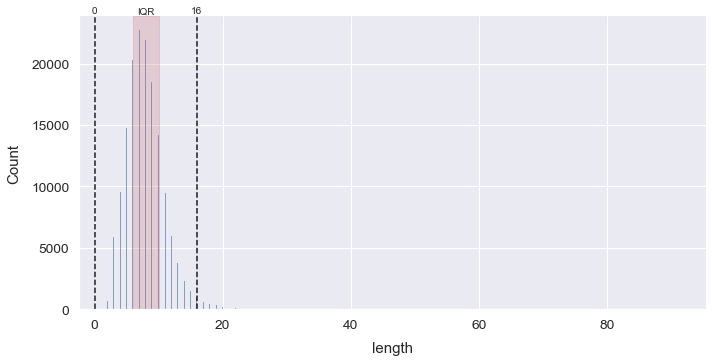

<IPython.core.display.Javascript object>

In [25]:
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["length"], g.axes[0, 0], num_format=".0f")

           n_trimmed  pct_trimmed
length         1,974            1
total_obs      1,974            1


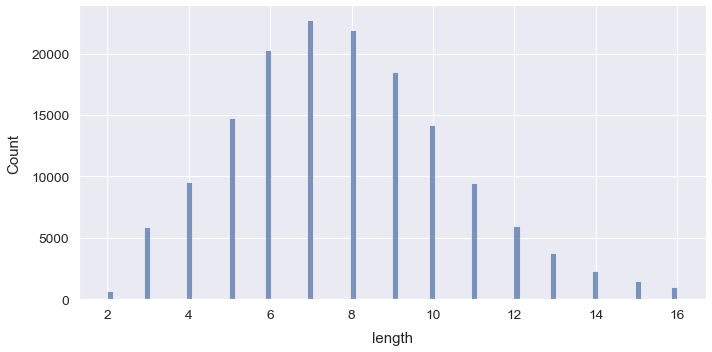

<IPython.core.display.Javascript object>

In [26]:
inlier_idx = outliers.tukey_trim(samp_vocab["length"]).index
samp_vocab = samp_vocab.loc[inlier_idx]
sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)

16 seems like a natural cutoff for word length, and it's what Tukey's IQR proximity rule dictates. I rewrite my token pattern to match sequences between two and 16 characters (inclusive).

In [27]:
token_pattern = r"(?i)\b[a-z_]{2,16}\b"
token_pattern

'(?i)\\b[a-z_]{2,16}\\b'

<IPython.core.display.Javascript object>

A related source of noise are strings with repetitive character (or word) sequences.

In [28]:
samp_vocab.sort_values("uniq_ratio").head(10)

,term,freq,length,uniq_ratio
87906,__________,2,10,0.100000
111602,wooooooooooooo,1,14,0.142857
92936,doodoodoodoo,2,12,0.166667
119287,______,1,6,0.166667
129696,cccccc,1,6,0.166667
24775,aaaaa,26,5,0.200000
146774,eeeee,1,5,0.200000
117877,rrrrr,1,5,0.200000
109162,xxxxx,1,5,0.200000
142403,whooooohooooooos,1,16,0.250000


<IPython.core.display.Javascript object>

The above terms with repetitive sequences have low character uniqueness ratios, i.e. the ratio of character types to character tokens. That's how I'll filter them out.

Note: long multi-word amalgamations also have low character uniqueness simply because of their length, but I've already weeded those out.

<AxesSubplot:xlabel='uniq_ratio', ylabel='Count'>

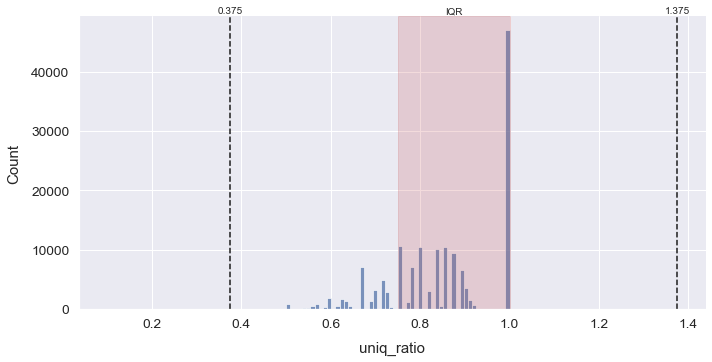

<IPython.core.display.Javascript object>

In [29]:
g = sns.displot(data=samp_vocab, x="uniq_ratio", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["uniq_ratio"], g.axes[0, 0], num_format=".3f")

The lower Tukey fence is located at 0.375. That seems like a reasonable cutoff.

In [30]:
steps = [
    re.compile(token_pattern).findall,
    partial(lang.uniq_char_thresh, thresh=0.375),
    " ".join,
]

df["text"] = lang.chain_processors(df.loc[:, "text"], steps, n_jobs=-1)

df["text"].head(10)

asin
B000050AUH    philips sonicare standard brush head sonic wav...
B000050B62    norelco deluxe reflex action cord cordless rec...
B000050B63    norelco quadra action cord cordless rechargeab...
B000050B64    norelco quadra action cord cordless rechargeab...
B000050B65    norelco deluxe quadra action cord cordless rec...
B000050B6B    philips norelco shaving heads replacement razo...
B000050B6H    philips norelco cool skin replacement heads fo...
B000050FDE    oral professional care power toothbrush the or...
B0000530JE    gillette sensorexcel cartridges pack of gillet...
B0000530S8    colgate baking soda peroxide whitening fluorid...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [31]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=token_pattern)

samp_vocab.sort_values("uniq_ratio")

,term,freq,length,uniq_ratio
95997,earpieceearpiece,1,16,0.375
141470,heeeeere,1,8,0.375
73394,lavalval,2,8,0.375
120816,boomboom,1,8,0.375
113527,bilibili,1,8,0.375
...,...,...,...,...
10074,cloths,141,6,1.000
80849,pouvez,2,6,1.000
10929,demons,123,6,1.000
87193,makuno,2,6,1.000


<IPython.core.display.Javascript object>

In [32]:
if RUN_LANGDETECT:
    with joblib.Parallel(n_jobs=-1, prefer="processes") as workers:
        detect_lang = joblib.delayed(langdetect.detect)
        df["lang"] = workers(detect_lang(x) for x in df.loc[:, "text"])
        df["lang"].to_json("data/langdetect.json")
else:
    df["lang"] = pd.read_json("data/langdetect.json", typ="series")
df["lang"].value_counts()

en    1089074
es       1016
it        214
fr        190
pt        134
de        114
nl        114
no        108
da         87
id         59
ca         46
sv         40
af         37
so         24
ro         24
pl         23
tl         17
sl         13
et         12
hr         12
cs         11
cy         10
sw          9
hu          6
lt          5
tr          5
sk          3
sq          3
fi          1
vi          1
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [33]:
df = df.loc[df.lang == "en"]
df["lang"].value_counts()

en    1089074
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [34]:
samp_vocab.loc[samp_vocab.term.str.contains("_")].sample(10)

,term,freq,length,uniq_ratio
117824,_bonus,1,6,1.000000
151192,bk_littledog,1,12,0.833333
148134,clock_speed,1,11,0.818182
125651,paper_finish,1,12,0.833333
60645,green_compliant,4,15,0.866667
131716,this_item,1,9,0.777778
90829,viper_l,2,7,1.000000
141688,wireless_lan,1,12,0.750000
102093,wotf_movie,1,10,0.900000
133493,product_model,1,13,0.846154


<IPython.core.display.Javascript object>

I'm not interested in any of the underscores already in the data, only ones that I might add.

In [35]:
# Replace underscores with space
df = df.assign(text=df.text.str.replace(r"(_+)", " ", regex=True))
df["text"].str.contains("_").sum()

0

<IPython.core.display.Javascript object>

For starters, I already have a lot of high quality brand phrases at my disposal. These are genuine multi-word expressions which should be understood as such by the model. Perhaps these will be too highly correlated with the one-hot-encoded brands, but I can easily remove one or the other from the feature matrix.

In [36]:
brand_ng = df.loc[:, "brand"].drop_duplicates().str.split("_").map(tuple)
brand_ng = brand_ng.loc[brand_ng.map(len) > 1]
brand_ng

asin
B000050AUH               (philips, sonicare)
B000050B6B                (philips, norelco)
B0000531WK                    (oreal, paris)
B0000532QF                  (tom, of, maine)
B000066SYD                     (aqua, fresh)
                           ...              
B00008YGO2                    (mumbo, jumbo)
B000ASBKGA                    (cta, digital)
B0017IK8W4                    (deep, silver)
B001K7HUUK           (alawar, entertainment)
B00GQVGV9Q    (big, leap, studios, pvt, ltd)
Name: brand, Length: 7364, dtype: object

<IPython.core.display.Javascript object>

I search for collocations in the text in a stratified fashion, scanning the documents of each 'main_cat' category as a separate corpus. The goal is to find ngrams which are peculiar to each category. I use pointwise mutual information (PMI) to identify bigrams.

In [37]:
cat_bg = lang.stratified_ngrams(
    df,
    n=2,
    text="text",
    cat="main_cat",
    tokenizer=re.compile(token_pattern).findall,
    metric="pmi",
    stopwords="nltk_english",
    min_freq=100,
    n_jobs=-1,
)
cat_bg

,bigram,score,main_cat
0,"(tom, maine)",9.641619,all beauty
1,"(old, spice)",9.456347,all beauty
2,"(pro, health)",9.002064,all beauty
3,"(diamond, fx)",8.968957,all beauty
4,"(philips, sonicare)",8.559704,all beauty
...,...,...,...
156669,"(new, game)",0.549146,video games
156670,"(game, players)",0.467959,video games
156671,"(game, world)",0.394567,video games
156672,"(play, new)",-0.051317,video games


<IPython.core.display.Javascript object>

Next, I filter the bigrams so that there are no pairs which contain just one word type, e.g. ('same', 'same').

In [38]:
def unique_filter(tuples):
    size = np.array([len(x) for x in tuples])
    n_unique = np.array([len(set(x)) for x in tuples])
    return n_unique == size

<IPython.core.display.Javascript object>

In [39]:
cat_bg = cat_bg.loc[unique_filter(cat_bg.bigram)]
cat_bg

,bigram,score,main_cat
0,"(tom, maine)",9.641619,all beauty
1,"(old, spice)",9.456347,all beauty
2,"(pro, health)",9.002064,all beauty
3,"(diamond, fx)",8.968957,all beauty
4,"(philips, sonicare)",8.559704,all beauty
...,...,...,...
156669,"(new, game)",0.549146,video games
156670,"(game, players)",0.467959,video games
156671,"(game, world)",0.394567,video games
156672,"(play, new)",-0.051317,video games


<IPython.core.display.Javascript object>

In [40]:
# Merge ngrams into single list
phrases = cat_bg.bigram.append(brand_ng).drop_duplicates().to_list()
display(len(phrases))
phrases[:10]

129815

[('tom', 'maine'),
 ('old', 'spice'),
 ('pro', 'health'),
 ('diamond', 'fx'),
 ('philips', 'sonicare'),
 ('face', 'paint'),
 ('brand', 'new'),
 ('brush', 'head'),
 ('high', 'quality'),
 ('new', 'high')]

<IPython.core.display.Javascript object>

In [41]:
df["text"] = lang.regex_tokenize(df.loc[:, "text"], token_pattern, n_jobs=-1)

ngram_tokenize = nltk.MWETokenizer(phrases).tokenize
df["text"] = df.loc[:, "text"].map(ngram_tokenize).str.join(" ")

df["text"].head()

asin
B000050AUH    philips_sonicare standard brush_head sonic wav...
B000050B62    norelco deluxe reflex action cord cordless rec...
B000050B63    norelco quadra action cord cordless rechargeab...
B000050B64    norelco quadra action cord cordless rechargeab...
B000050B65    norelco deluxe quadra action cord cordless rec...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [42]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=token_pattern)
samp_vocab.sample(10)

,term,freq,length,uniq_ratio
144668,reason_let,2,10,0.900000
188164,knockaround,1,11,0.727273
6544,pivot,246,5,1.000000
37239,game_cards,32,10,0.900000
146364,civic_cx,2,8,0.625000
104312,zoom_wide,6,9,0.888889
8318,dave,183,4,1.000000
15182,field_confident,90,15,0.666667
101026,outsole_designed,7,16,0.687500
173819,rippercase,1,10,0.700000


<IPython.core.display.Javascript object>

In [43]:
if os.path.exists("data/model_data"):
    shutil.rmtree("data/model_data")

df.to_parquet(
    "data/model_data",
    engine="pyarrow",
    index=True,
    partition_cols="main_cat",
)

<IPython.core.display.Javascript object>


# Modeling
## Train-Test Split

In [3]:
df = pd.read_parquet("data/model_data", engine="pyarrow")
df.head()

,text,title,brand,lang,main_cat
asin,,,,,
B000050AUH,philips_sonicare standard brush_head sonic wav...,philips sonicare standard brush head,philips_sonicare,en,all beauty
B000050B62,norelco deluxe reflex action cord cordless rec...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,en,all beauty
B000050B63,norelco quadra action cord cordless rechargeab...,norelco 6826xl quadra action cord/cordless rec...,norelco,en,all beauty
B000050B64,norelco quadra action cord cordless rechargeab...,norelco 6865xl quadra action cord/cordless rec...,norelco,en,all beauty
B000050B65,norelco deluxe quadra action cord cordless rec...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,en,all beauty


<IPython.core.display.Javascript object>

In [4]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((816805,), (272269,), (816805,), (272269,))

<IPython.core.display.Javascript object>

In [5]:
X_trains, y_trains = utils.aligned_sample(
    X_train, y_train, size=10000, weights=compute_sample_weight("balanced", y_train)
)
X_tests, y_tests = utils.aligned_sample(
    X_test, y_test, size=5000, weights=compute_sample_weight("balanced", y_test)
)

<IPython.core.display.Javascript object>

In [6]:
fv = FreqVectorizer(
    lowercase=False,
    decode_html_entities=False,
    token_pattern=r"(?i)\b[a-z_]{2,16}\b",
)

fv

FreqVectorizer(decode_html_entities=False, lowercase=False,
               token_pattern='(?i)\\b[a-z_]{2,16}\\b')

<IPython.core.display.Javascript object>

The [User Guide](https://scikit-learn.org/stable/modules/sgd.html#sgd) emphasizes that `SGDClassifier` is sensitive to feature scale. However, since word frequencies and brand occurrences are already on the same scale, there is no need to include a scaler.

A related concern is vector normalization (sample scale). The User Guide states that the default learning rate formula (`learning_rate='optimal'`) assumes "that the norm of the training samples is approx. 1." Since the norm of the semantic vector space is a configurable parameter of `FreqVectorizer`, and the norm of the brand space is 1, I'll hold off on including a `Normalizer` in the baseline pipeline. To be sure, the norm of the concatenated vectors is not 1, but I'll wait until further along in the modeling process to try adding a `Normalizer`.

In [7]:
pipe = Pipeline(
    [
        ("vec", fv),
        ("cls", "passthrough"),
    ],
    verbose=True,
)
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(decode_html_entities=False, lowercase=False,
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls', 'passthrough')],
         verbose=True)

<IPython.core.display.Javascript object>

In [8]:
def plot_confusion_matrix(
    estimator,
    X_test=X_test,
    y_test=y_test,
    dst=None,
    xticks_rotation="vertical",
    **kwargs,
):
    ax = plotting.confusion_matrix(
        estimator,
        X_test,
        y_test,
        xticks_rotation=xticks_rotation,
        **kwargs,
    )
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    ax.set_title(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}", pad=5)
    if isinstance(dst, str):
        plt.savefig(dst)
    return ax

<IPython.core.display.Javascript object>

In [9]:
def get_report(estimator, X_test=X_test, y_test=y_test):
    report = classification_report(y_test, estimator.predict(X_test), output_dict=True)
    report = pd.DataFrame(report).T
    report.loc["accuracy", "support"] = report["support"].max()
    return report

<IPython.core.display.Javascript object>

In [10]:
def extract_coefficients(
    pipeline,
    classifier="cls",
    vectorizer="vec",
    selection="sel",
):
    columns = np.array(pipeline[vectorizer].get_feature_names())
    #     columns = columns[pipeline[selection].get_support()]
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

# Baseline SVM

In [11]:
sgd = SGDClassifier(
    loss="hinge",
    class_weight="balanced",
    n_jobs=-1,
)

pipe.set_params(cls=sgd)

Pipeline(steps=[('vec',
                 FreqVectorizer(decode_html_entities=False, lowercase=False,
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [12]:
if "svm_1" in FIT_MODELS:
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_1.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_1.joblib")
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(decode_html_entities=False, lowercase=False,
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [13]:
len(pipe["vec"].get_feature_names())

514437

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.96, Balanced Accuracy: 0.90'}, xlabel='Predicted label', ylabel='True label'>

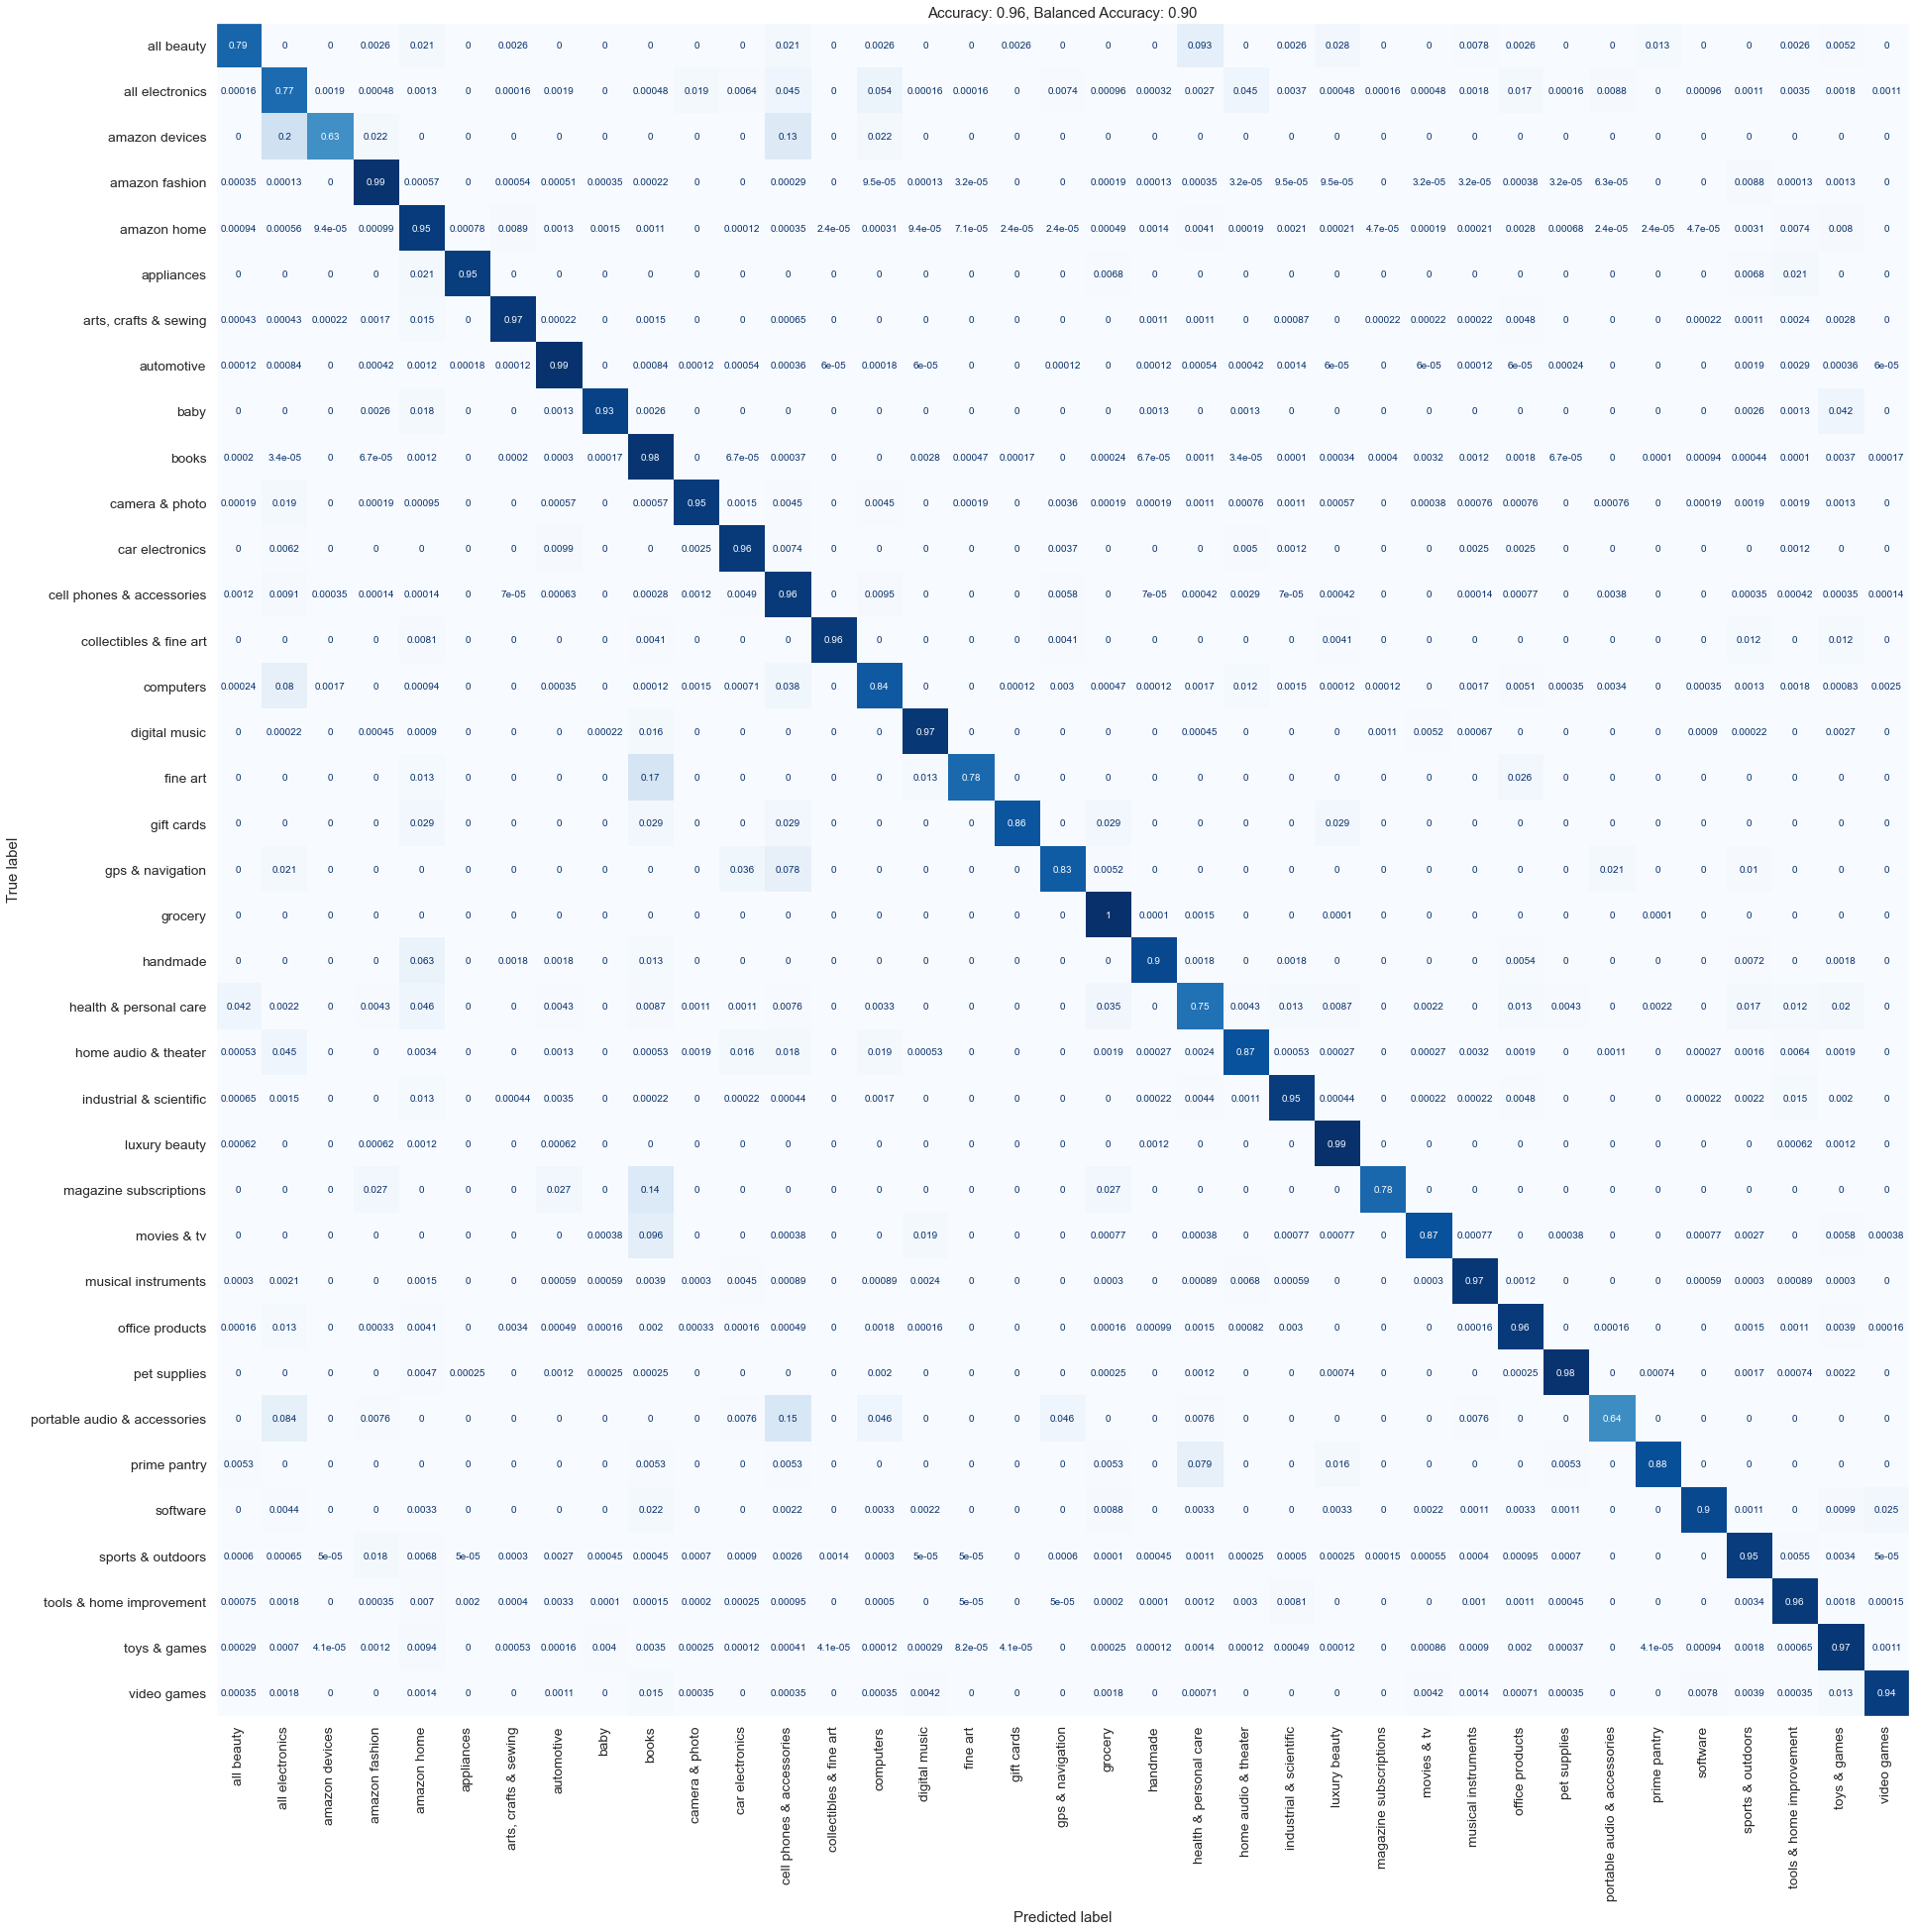

<IPython.core.display.Javascript object>

In [14]:
plot_confusion_matrix(pipe, dst="figures/svm_1_cm.svg")

In [15]:
coef = extract_coefficients(pipe)
coef.sort_values("all electronics", ascending=False).head(10)

,all beauty,all electronics,amazon devices,amazon fashion,amazon home,appliances,"arts, crafts & sewing",automotive,baby,books,...,musical instruments,office products,pet supplies,portable audio & accessories,prime pantry,software,sports & outdoors,tools & home improvement,toys & games,video games
riorand,-0.073449,1.406800,-0.012242,0.000000,-0.102642,-0.004081,-0.009521,-0.061206,-0.004897,0.000000,...,-0.058145,-0.002720,-0.038253,-0.024484,-0.006121,0.000000,-0.044069,-0.102827,-0.125753,-0.027203
amscope,-0.013354,1.004947,-0.003895,-0.019042,-0.030133,0.000000,-0.016322,-0.032643,-0.004897,-0.004451,...,-0.036723,-0.005441,0.000000,0.000000,0.000000,-0.014690,-0.056310,-0.055086,-0.010016,-0.005441
javoedge,-0.020031,0.975248,0.532955,-0.010881,-0.016008,-0.006121,-0.005441,0.000000,-0.007345,0.000000,...,-0.009181,-0.013601,-0.044373,-0.091815,0.000000,-0.002448,-0.015914,-0.006121,-0.008903,0.000000
kenable,-0.010016,0.968755,-0.001669,-0.008161,-0.002825,0.000000,-0.008161,-0.012241,-0.003672,0.000000,...,-0.094867,-0.004080,0.000000,-0.012242,0.000000,-0.003672,0.000000,-0.020810,-0.023370,-0.004080
silverstone,0.000000,0.948565,-0.002226,0.000000,-0.010680,-0.002040,0.052196,-0.025842,0.000000,-0.006677,...,-0.006120,-0.005441,0.000000,0.000000,0.000000,-0.001224,-0.017138,-0.017138,-0.022030,-0.005152
thermaltake,-0.008903,0.920054,-0.024484,0.000000,-0.006592,-0.025503,-0.016322,-0.052445,0.000000,0.000000,...,-0.013771,-0.024482,0.000000,-0.017003,0.000000,0.000000,-0.050189,-0.062431,-0.004451,-0.002720
accessory_genie,0.000000,0.909640,-0.003895,0.000000,-0.002825,0.000000,0.000000,-0.002720,-0.002448,0.000000,...,-0.033663,-0.019042,0.000000,-0.004081,0.000000,0.000000,-0.035500,-0.003672,-0.001113,-0.006801
ocz,0.000000,0.817314,-0.004452,0.000000,-0.002825,-0.002040,0.000000,-0.040804,-0.001224,-0.008903,...,-0.010711,-0.005441,0.000000,-0.004761,0.000000,-0.003672,-0.026931,0.000000,-0.005564,-0.023122
antec,-0.003339,0.815362,-0.005565,0.000000,-0.018833,-0.003060,0.000000,-0.012241,0.000000,0.000000,...,-0.067325,-0.001360,0.000000,-0.002040,0.000000,0.000000,-0.048965,-0.046517,-0.005564,0.000000
trendnet,-0.004451,0.814138,-0.009460,0.000000,-0.004708,-0.007141,0.000000,-0.002720,-0.002448,-0.003339,...,-0.012241,-0.009521,0.000000,-0.004081,-0.015914,-0.034276,0.000000,-0.015914,0.000000,-0.021762


<IPython.core.display.Javascript object>

# Add Stopwords

In [16]:
pipe["vec"].set_params(stop_words="nltk_english")

FreqVectorizer(decode_html_entities=False, lowercase=False,
               stop_words='nltk_english',
               token_pattern='(?i)\\b[a-z_]{2,16}\\b')

<IPython.core.display.Javascript object>

In [17]:
if "svm_2" in FIT_MODELS:
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_2.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_2.joblib")
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(decode_html_entities=False, lowercase=False,
                                stop_words='nltk_english',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [18]:
len(pipe["vec"].get_feature_names())

514292

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.96, Balanced Accuracy: 0.91'}, xlabel='Predicted label', ylabel='True label'>

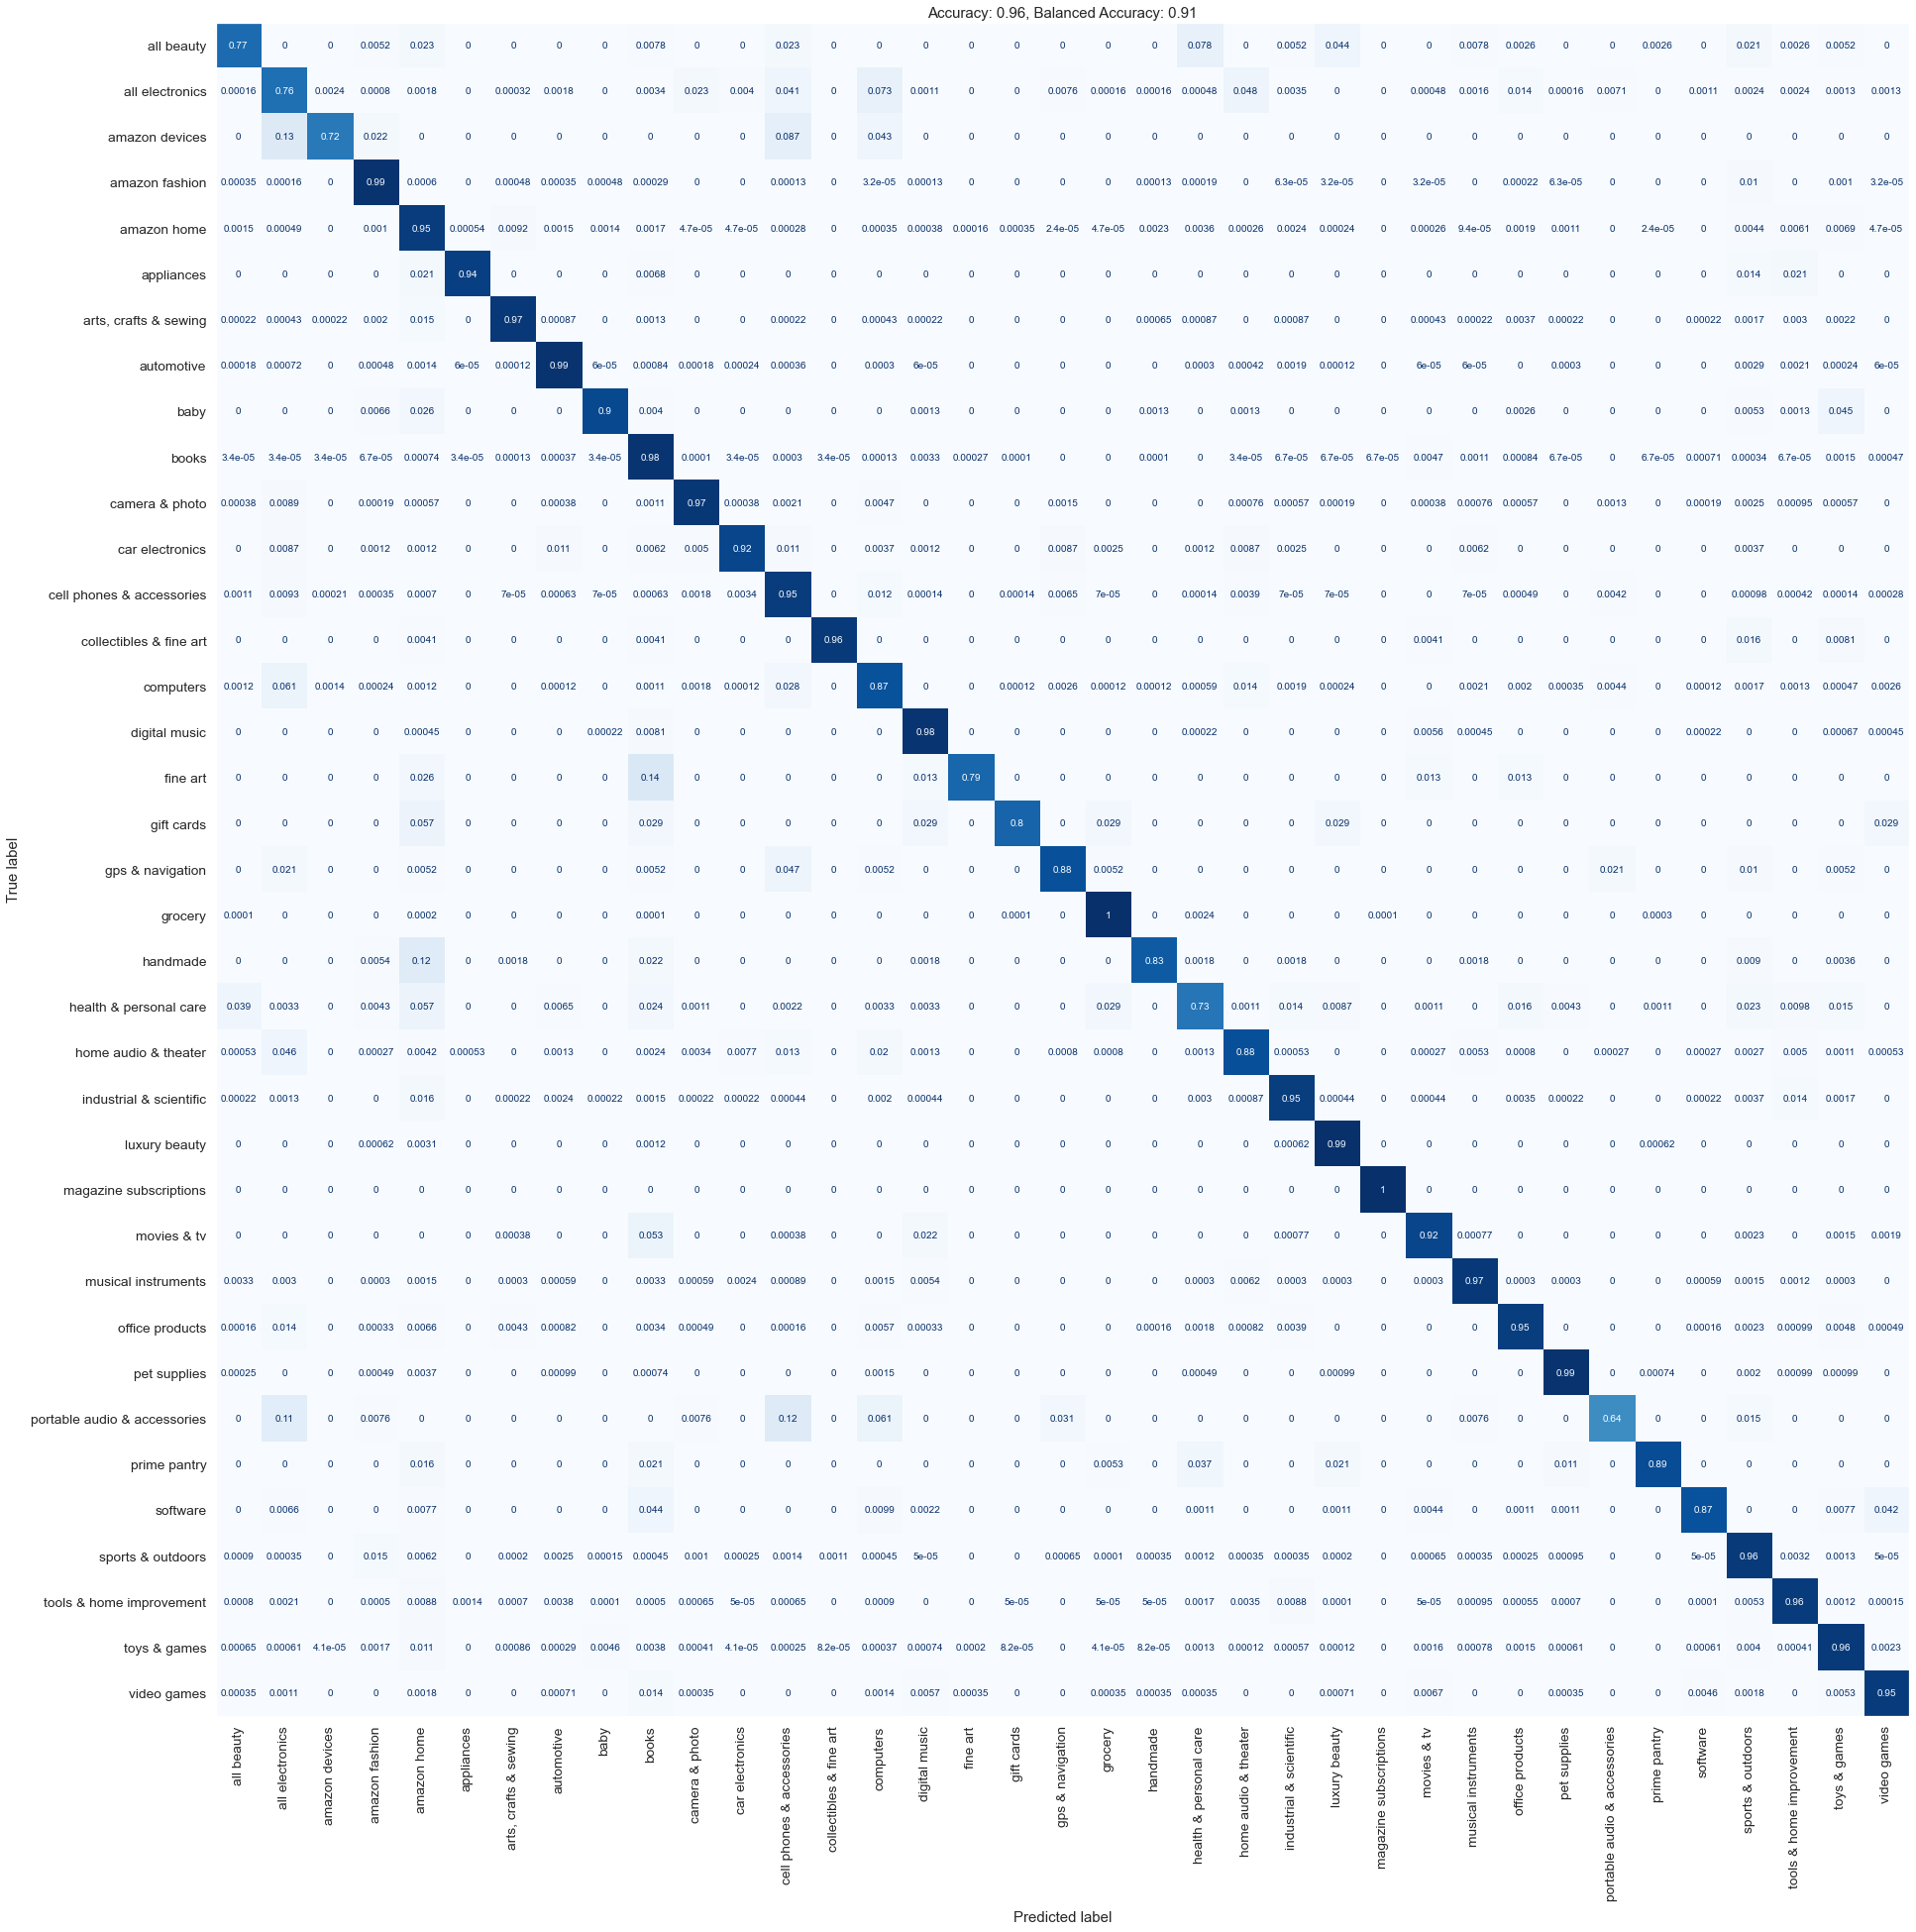

<IPython.core.display.Javascript object>

In [19]:
plot_confusion_matrix(pipe, dst="figures/svm_2_cm.svg")

# SGD Classifier Selection

In [20]:
sgd_grid = {
    "cls__loss": ["hinge", "squared_hinge", "log", "modified_huber"],
    "cls__penalty": ["l1", "l2"],
    "cls__alpha": sp.stats.loguniform(1e-8, 1.0),
    "vec__use_idf": [True, False],
    "vec__binary": [True, False],
    "vec__norm": ["l1", "l2", None],
}

sgd_grid

{'cls__loss': ['hinge', 'squared_hinge', 'log', 'modified_huber'],
 'cls__penalty': ['l1', 'l2'],
 'cls__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x24719addbe0>,
 'vec__use_idf': [True, False],
 'vec__binary': [True, False],
 'vec__norm': ['l1', 'l2', None]}

<IPython.core.display.Javascript object>

In [21]:
if "loss" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        sgd_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/loss_cv.joblib",
        kind="hrand",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    loss_results = gs.cv_results_
else:
    loss_results = joblib.load("sweeps/loss_cv.joblib")

loss_results = selection.prune_cv(loss_results)
loss_results.head(10)

,alpha,loss,penalty,binary,norm,use_idf,params,mean_fit_time,mean_score,rank_score
0,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",241.589407,0.963798,1
1,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",121.395599,0.953789,2
2,7.157636e-07,log,l2,False,l2,True,"{'cls__alpha': 7.15763577656479e-07, 'cls__los...",102.892204,0.949059,3
3,1.605315e-08,log,l2,False,l1,True,"{'cls__alpha': 1.6053147327650663e-08, 'cls__l...",99.634805,0.947215,4
4,7.157636e-07,log,l2,False,l2,True,"{'cls__alpha': 7.15763577656479e-07, 'cls__los...",26.191196,0.935344,5
5,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",26.031597,0.933922,6
6,1.605315e-08,log,l2,False,l1,True,"{'cls__alpha': 1.6053147327650663e-08, 'cls__l...",28.755394,0.933267,7
7,3.082426e-06,hinge,l2,False,l2,False,"{'cls__alpha': 3.0824261182174037e-06, 'cls__l...",24.616992,0.928700,8
8,7.857063e-06,hinge,l2,False,l2,False,"{'cls__alpha': 7.857063428799315e-06, 'cls__lo...",23.931392,0.924689,9
9,4.430582e-08,log,l2,True,l1,True,"{'cls__alpha': 4.4305817166390654e-08, 'cls__l...",27.540397,0.924622,10


<IPython.core.display.Javascript object>

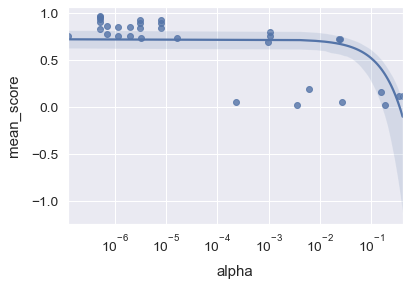

<IPython.core.display.Javascript object>

In [22]:
ax = sns.regplot(
    data=loss_results.query("loss == 'hinge'"),
    x="alpha",
    y="mean_score",
)
ax.set_xscale("log")

## Fit SVM

In [23]:
loss_params = loss_results.loc[0, "params"]
display(loss_params)
pipe.set_params(**loss_params)

{'cls__alpha': 5.25503769545935e-07,
 'cls__loss': 'hinge',
 'cls__penalty': 'l2',
 'vec__binary': True,
 'vec__norm': 'l2',
 'vec__use_idf': True}

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False, norm='l2',
                                stop_words='nltk_english',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [24]:
if "svm_3" in FIT_MODELS:
    pipe.fit(X_train, y_train)

    joblib.dump(pipe, "models/svm_3.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_3.joblib")
pipe

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False, norm='l2',
                                stop_words='nltk_english',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.97, Balanced Accuracy: 0.92'}, xlabel='Predicted label', ylabel='True label'>

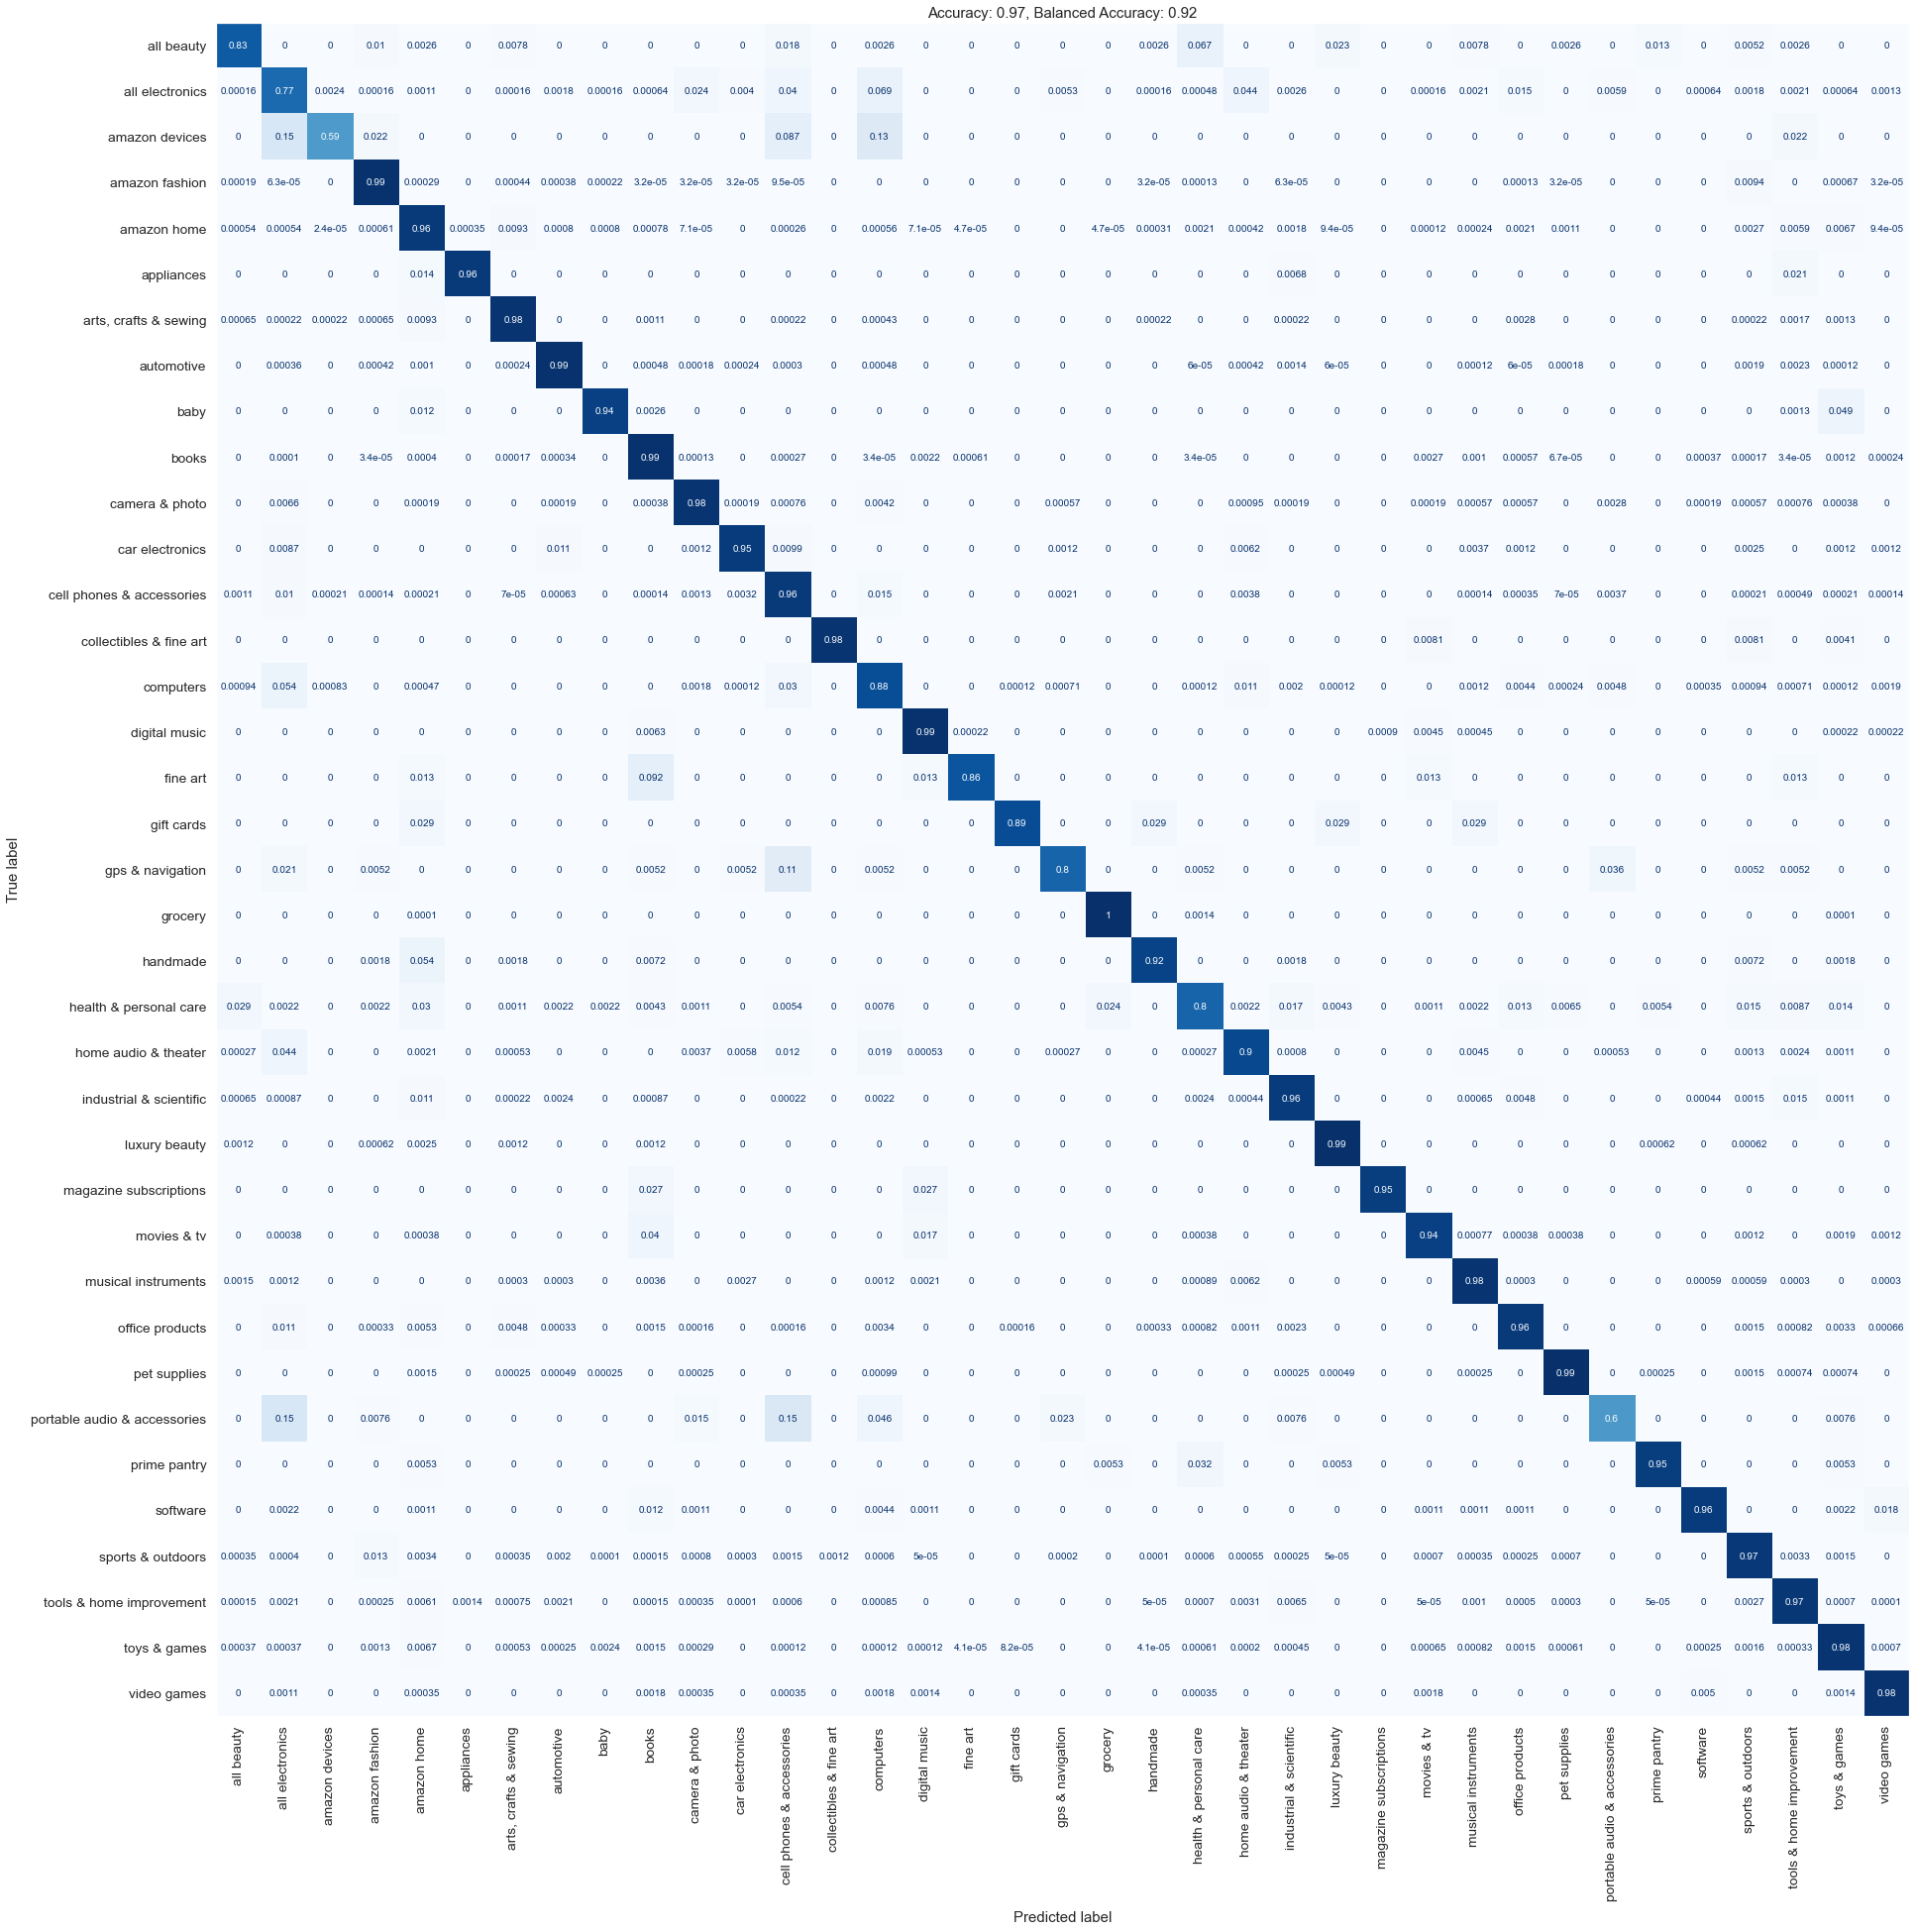

<IPython.core.display.Javascript object>

In [25]:
plot_confusion_matrix(pipe, dst="figures/svm_3_cm.svg")

In [26]:
coef = extract_coefficients(pipe)
coef.sort_values("all electronics", ascending=False).head(10)
coef.max(axis=1).sort_values()

strykersville        0.000000
lankins              0.000000
elenor               0.000000
randthe              0.000000
thegood              0.000000
                      ...    
magazine            69.650836
gift_card          104.646039
size_medium        105.767090
span_class         125.801973
color_secondary    125.895042
Length: 514292, dtype: float64

<IPython.core.display.Javascript object>

# Optimize Learning Rate

In [27]:
learn_grid = [
    {
        "learning_rate": ["constant", "adaptive"],
        "eta0": sp.stats.loguniform(1e-4, 1e4),
        "average": [True, False],
    },
    {
        "learning_rate": ["optimal"],
        "average": [True, False],
    },
]
learn_grid

[{'learning_rate': ['constant', 'adaptive'],
  'eta0': <scipy.stats._distn_infrastructure.rv_frozen at 0x24729925c70>,
  'average': [True, False]},
 {'learning_rate': ['optimal'], 'average': [True, False]}]

<IPython.core.display.Javascript object>

In [28]:
if "learn" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        learn_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/learn_cv.joblib",
        kind="hrand",
        add_prefix="cls__",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    learn_results = gs.cv_results_
else:
    learn_results = joblib.load("sweeps/learn_cv.joblib")

learn_results = selection.prune_cv(learn_results)
learn_results.head(10)

C:\Users\ndgig\Documents\Flatiron\Capstone\dsc-capstone\tools\_validation.py:106: UserWarning: 'learn_cv.joblib' already exists and will be overwritten.
  warnings.warn(f"'{basename}' already exists and will be overwritten.")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 10000
max_resources_: 816805
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 10000
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 1
n_candidates: 27
n_resources: 30000
Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 2
n_candidates: 9
n_resources: 90000
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 270000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 1
n_resources: 810000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


['sweeps\\learn_cv.joblib']

,average,eta0,learning_rate,params,mean_fit_time,mean_score,rank_score
0,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",2718.412539,0.964341,1
1,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",971.841199,0.954659,2
2,False,1.656650,adaptive,"{'cls__average': False, 'cls__eta0': 1.6566501...",362.309605,0.954233,3
3,False,0.857235,constant,"{'cls__average': False, 'cls__eta0': 0.8572352...",85.645006,0.952689,4
4,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",289.311396,0.938111,5
5,False,1.656650,adaptive,"{'cls__average': False, 'cls__eta0': 1.6566501...",117.517600,0.937444,6
6,False,0.857235,constant,"{'cls__average': False, 'cls__eta0': 0.8572352...",36.053796,0.937389,7
7,False,1.925135,adaptive,"{'cls__average': False, 'cls__eta0': 1.9251349...",116.465399,0.936867,8
8,False,0.086955,constant,"{'cls__average': False, 'cls__eta0': 0.0869545...",26.184200,0.935878,9
9,False,0.081826,constant,"{'cls__average': False, 'cls__eta0': 0.0818255...",87.510197,0.935878,9


<IPython.core.display.Javascript object>

In [34]:
learn_params = learn_results.loc[0, "params"]
display(learn_params)
pipe.set_params(**learn_params)

{'cls__average': True,
 'cls__eta0': 0.8416663608926325,
 'cls__learning_rate': 'adaptive'}

Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False, norm='l2',
                                stop_words='nltk_english',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [36]:
if "svm_4" in FIT_MODELS:
    pipe.fit(X_train, y_train)

    joblib.dump(pipe, "models/svm_4.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_4.joblib")
pipe

[Pipeline] ............... (step 1 of 2) Processing vec, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing cls, total=10.7min


Pipeline(steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False, norm='l2',
                                stop_words='nltk_english',
                                token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                use_idf=True)),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.97, Balanced Accuracy: 0.93'}, xlabel='Predicted label', ylabel='True label'>

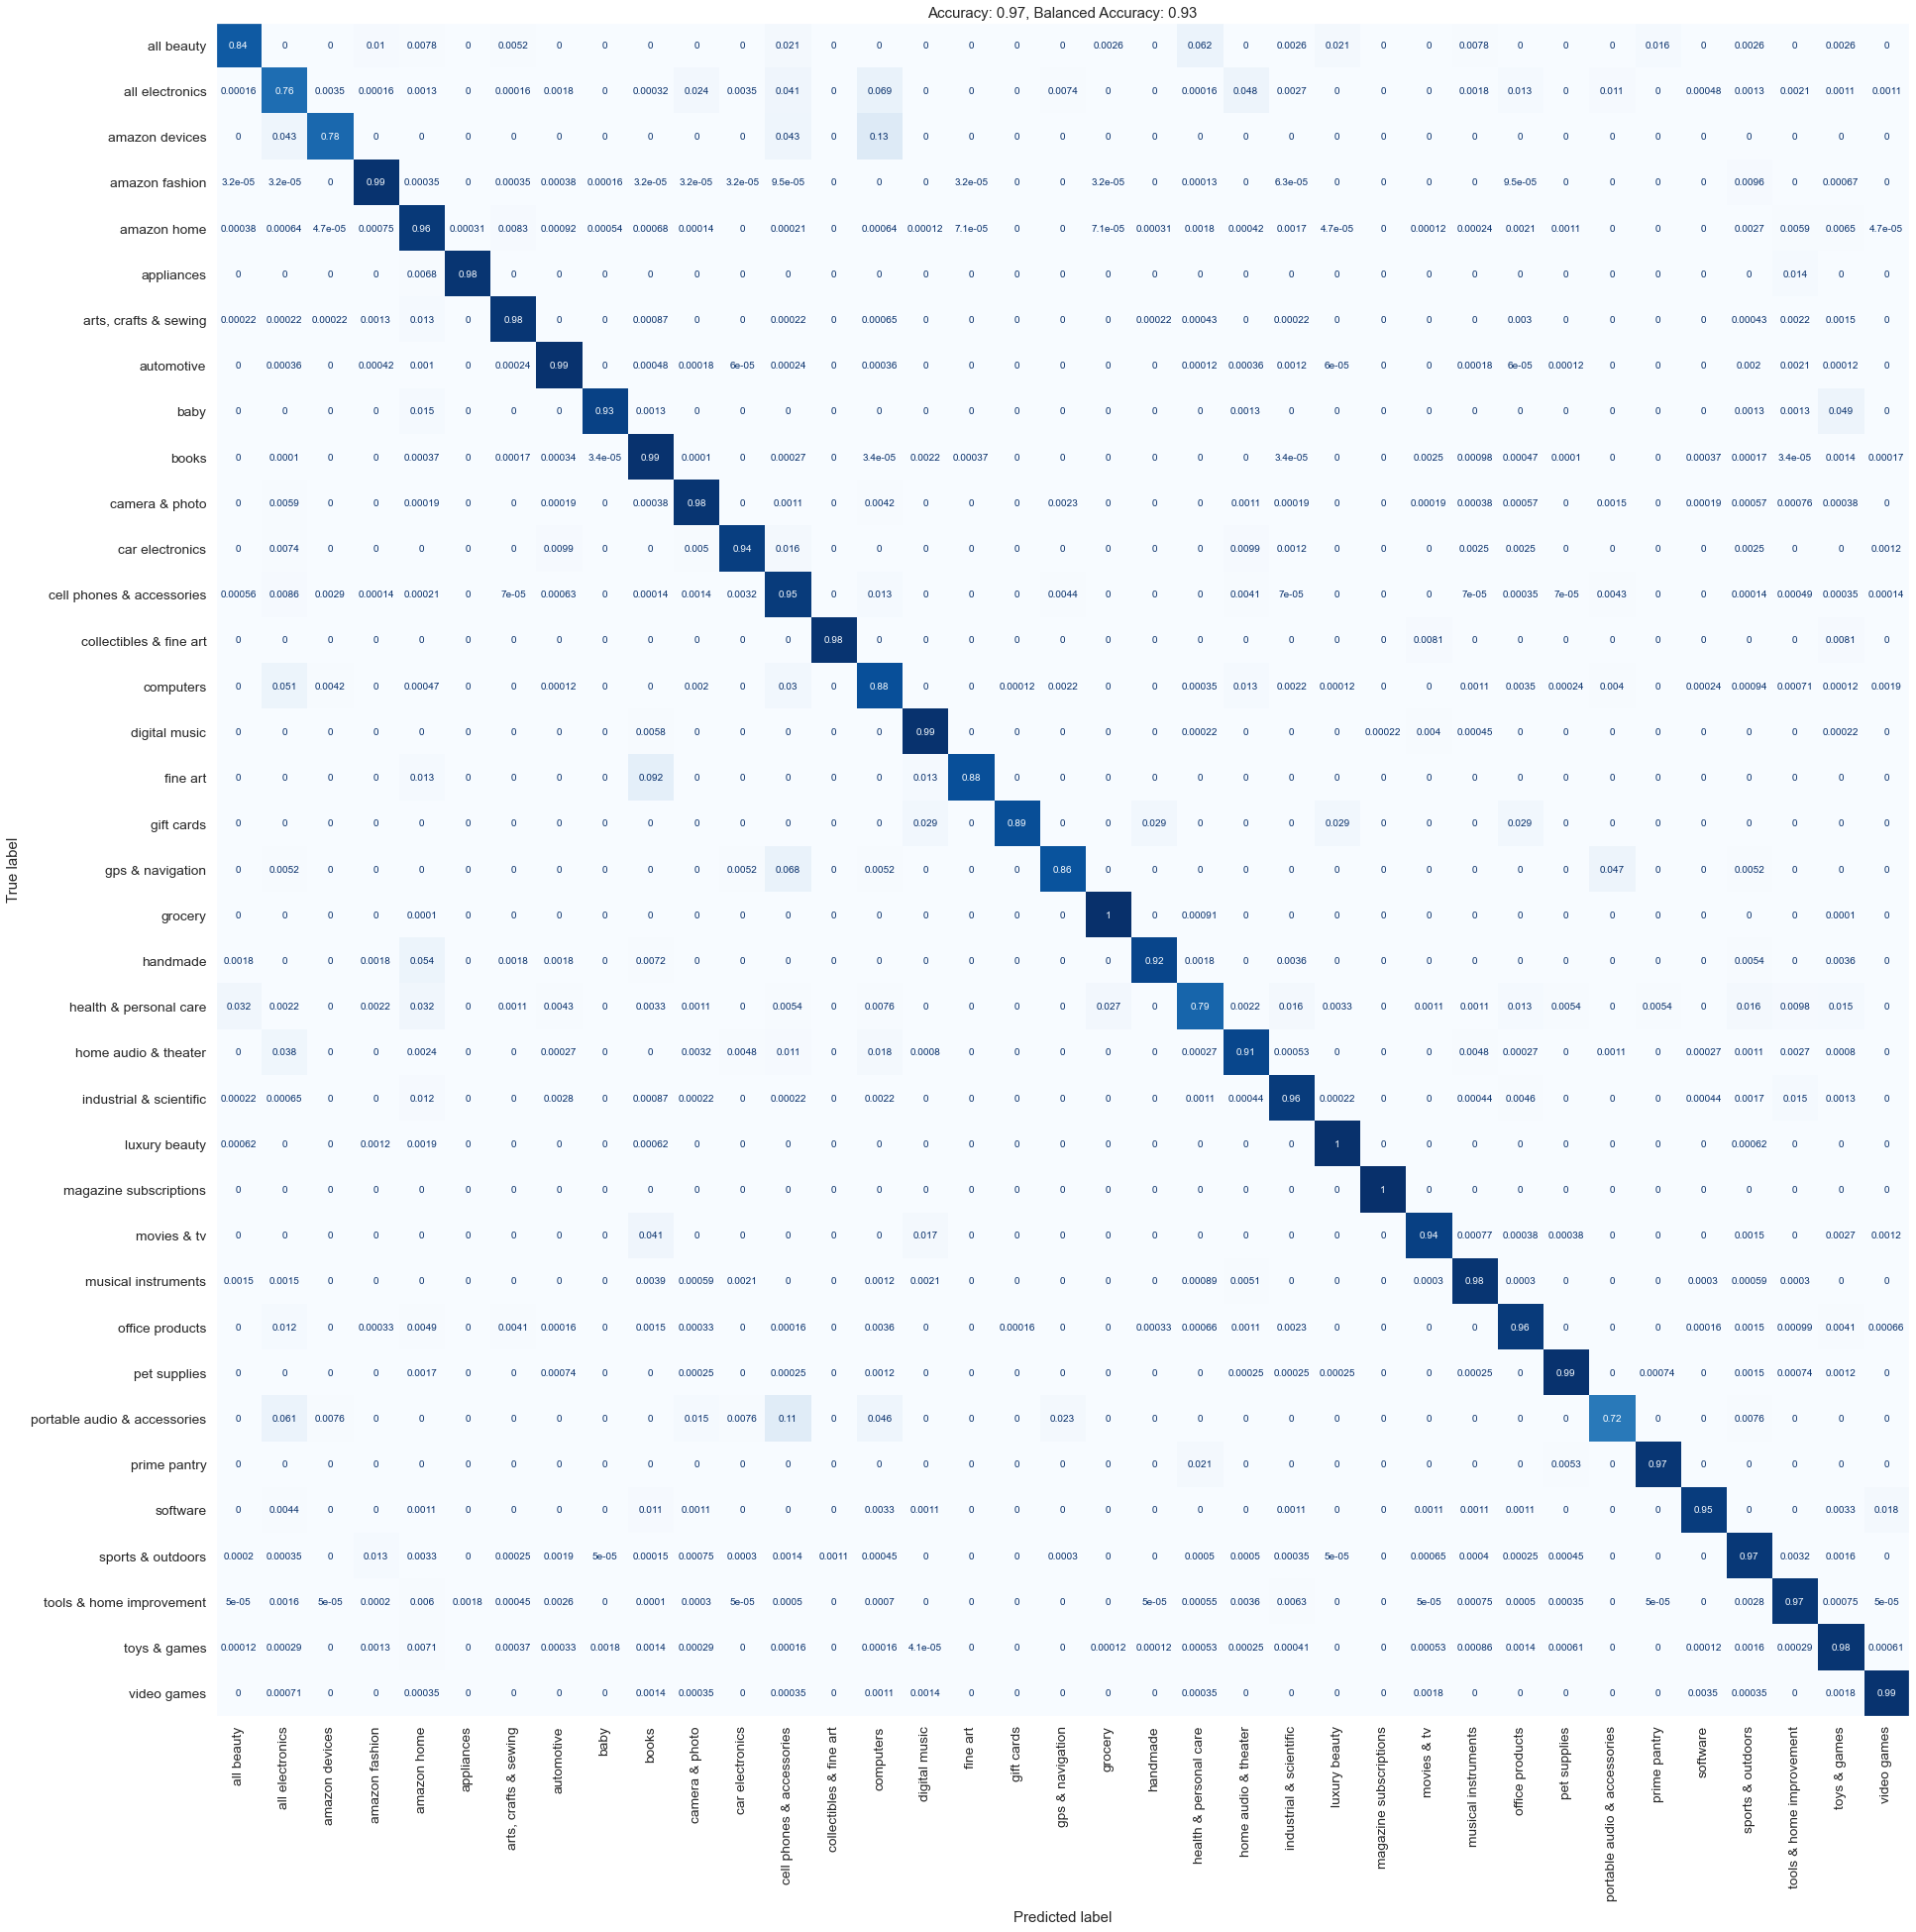

<IPython.core.display.Javascript object>

In [37]:
plot_confusion_matrix(pipe, dst="figures/svm_4_cm.svg")

# Interpretation

In [33]:
# for column in coef.columns:
#     display(coef[column].nlargest(10))

<IPython.core.display.Javascript object>